# Welcome to TXPipe: Running TXPipe & Exploring Its Outputs

Owner: Johanna Paine, slack: Johanna Paine, github: jgpaine   
12/2/22 

Edited by Kabelo Tsiane on 09/19/25

TXPipe is a pipeline to perform 3x2pt measurements for DESC.

"3x2pt" refers to the combined analysis of galaxy clustering and weak lensing, and involves the computation of three sets of two-point functions: the autocorrelation of galaxy shapes (shear-shear) the autocorrelation of galaxy positions (position-position or density-density) and the cross-correlation of lens galaxy positions and source galaxy shapes (shear-position).

This is a notebook that runs a TXPipe pipeline on a catalog that covers 1 square degreee of the sky, and then looks at a few of the outputs. This assumes you have installed [TXPipe](https://github.com/LSSTDESC/TXPipe) and [Jupyter](https://jupyter.org/install).

Our example's input catalog comes from simulation products from the CosmoDC2 simulation. CosmoDC2 arXiv: https://arxiv.org/abs/1907.06530 

This pipeline generates a wide range of files. In the files tab of Jupyter you can directly open the image (png) type outputs in `data/example/outputs` and `data/example/outputs_metadetect`. 

In [1]:
# Make it so we run this notebook from the directory above,
# since the pipeline expects to be there
import os
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

# Table of Contents

* [Running the pipeline](#run-pipeline)
* [HDF5 catalogs: shear tomography](#explore-cats)
* [Redshift PDFs: lens p(z)](#photoz-pdfs)
* [Redshift distributions: source n(z)](#photoz-bins)
* [Null test plots & data: the brighter-fatter effect](#brighter-fatter)
* [Maps: source catalog maps](#source-maps)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import ceci
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image
import txpipe.data_types
import healpy
import sacc
import logging
import yaml
from pprint import pprint

/Users/kabelo/TXPipe/conda/lib/python3.10/site-packages/ceci/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


---

# Running the Pipeline <a class="anchor" id="run-pipeline"></a>


First we will build a pipeline from a YAML format configuration file. That file describes the stages the pipeline should run, how they should be launched, the inputs to the start of the pipeline, and various other housekeeping info. The cells below prints out all the stages and then runs the pipeline with that configuration file.  


In [3]:
config_yaml = yaml.safe_load(open("examples/metadetect/pipeline.yml" )) 

# pprint is "pretty print" - it prints out nested dicts and similar
# more readably
pprint(config_yaml)

{'config': 'examples/metadetect/config.yml',
 'inputs': {'exposures': 'data/example/inputs/exposures.hdf5',
            'fiducial_cosmology': 'data/fiducial_cosmology.yml',
            'flow': 'data/example/inputs/example_flow.pkl',
            'photometry_catalog': 'data/example/inputs/photometry_catalog.hdf5',
            'random_cats_source': None,
            'shear_catalog': 'data/example/inputs/metadetect_shear_catalog.hdf5',
            'star_catalog': 'data/example/inputs/star_catalog.hdf5'},
 'launcher': {'interval': 1.0, 'name': 'mini'},
 'log_dir': 'data/example/logs_metadetect',
 'modules': 'txpipe txpipe.extensions.hos.fsb '
            'rail.creation.degraders.grid_selection '
            'rail.creation.engines.flowEngine rail.estimation.algos.nz_dir '
            'rail.estimation.algos.bpz_lite\n',
 'output_dir': 'data/example/outputs_metadetect',
 'pipeline_log': 'data/example/log.txt',
 'python_paths': ['submodules/WLMassMap/python/desc/', 'submodules/pyfsb'],
 'resume

In [4]:
config_filename = "examples/metadetect/pipeline.yml" 
pipeline = ceci.Pipeline.read(config_filename)

Now we can actually run the pipeline. This will take a few minutes.

If you run it a second time it will detect that the pipeline is already complete and will not re-run any commands.

In [5]:
pipeline.run()


Executing FlowCreator
Command is:
OMP_NUM_THREADS=1 PYTHONPATH=submodules/WLMassMap/python/desc/:submodules/pyfsb:$PYTHONPATH  python3 -m ceci rail.creation.engines.flowEngine.FlowCreator   --model=data/example/inputs/example_flow.pkl   --config=examples/metadetect/config.yml   --output=data/example/outputs_metadetect/ideal_specz_catalog.pq 
Output writing to data/example/logs_metadetect/FlowCreator.out

Job FlowCreator has completed successfully in 18.1 seconds seconds !

Executing TXStarCatalogSplitter
Command is:
OMP_NUM_THREADS=1 PYTHONPATH=submodules/WLMassMap/python/desc/:submodules/pyfsb:$PYTHONPATH  python3 -m txpipe TXStarCatalogSplitter   --star_catalog=data/example/inputs/star_catalog.hdf5   --config=examples/metadetect/config.yml   --binned_star_catalog=data/example/outputs_metadetect/binned_star_catalog.hdf5 
Output writing to data/example/logs_metadetect/TXStarCatalogSplitter.out

Job TXStarCatalogSplitter has completed successfully in 2.0 seconds seconds !

Executing TX

0

The pipeline has a few inputs and a great many outputs. We can list them all and their locations:

In [6]:
print("Inputs")
print("------")
for name, path in pipeline.overall_inputs.items():
    print(f"{name: <32}    {path}")    

print("")
print("Outputs")
print("------")

for name, path in pipeline.find_all_outputs().items():
    print(f"{name: <32}    {path}")

Inputs
------
shear_catalog                       data/example/inputs/metadetect_shear_catalog.hdf5
photometry_catalog                  data/example/inputs/photometry_catalog.hdf5
exposures                           data/example/inputs/exposures.hdf5
star_catalog                        data/example/inputs/star_catalog.hdf5
fiducial_cosmology                  data/fiducial_cosmology.yml
random_cats_source                  None
flow                                data/example/inputs/example_flow.pkl

Outputs
------
ideal_specz_catalog                 data/example/outputs_metadetect/ideal_specz_catalog.pq
binned_star_catalog                 data/example/outputs_metadetect/binned_star_catalog.hdf5
aux_lens_maps                       data/example/outputs_metadetect/aux_lens_maps.hdf5
e1_psf_residual_hist                data/example/outputs_metadetect/e1_psf_residual_hist.png
e2_psf_residual_hist                data/example/outputs_metadetect/e2_psf_residual_hist.png
T_frac_psf_residual_hist

---

# HDF5 catalogs: shear tomography  <a class="anchor" id="explore-cats"></a>

Catalogs in TXPipe are saved as HDF5 files, since these can be both read and written in parallel at NERSC very fast. To open the outputs that are .hdf5 files use the code below. 

(Not all the HDF5 files are catalogs. For example, some of them have maps that can be plotted with HealPix - we will look at those below).

Now we can open one of the the output hdf5 files and explore some of the data. We follow the [TXPipe HDF instructions](https://txpipe.readthedocs.io/en/latest/hdf5.html), and look first at shear tomography.

The "H" in HDF5 stands for hierarchical - just like a file system of folders and files, HDF files have groups and data sets. Let's look at the items in the root of the file, and then explore a group, `tomography` inside that:

In [31]:
f = h5py.File("./data/example/outputs_metadetect/shear_tomography_catalog.hdf5")

# f is the root object
print(f.keys())

# g is a group within it. Let's print all the datasets within g
g = f["counts"]
for key in g.keys():
    print(key)


<KeysViewHDF5 ['counts', 'provenance', 'response', 'tomography']>
N_eff
N_eff_2d
counts
counts_2d
mean_e1
mean_e1_2d
mean_e2
mean_e2_2d
sigma_e
sigma_e_2d


We plan to improve the TXPipe documentation and explain what all these things mean, but for now you may need to look at the code to determine what these are.

Here's part of `txpipe/source_selector.py` explaining what these are:
        
        Parameters
        ----------
        count: int
            The raw number of objects
        N_eff: int
            The effective number of objects
        mean_e: array or list
            Length 2. The mean ellipticity e1 and e2 in the bin
        sigma_e: float
            The ellipticity dispersion

The data sets ending in `_2D` are non-tomographic, and just contain statistics for the entire source sample. The others are arrays with values for each tomographic bin.

The source bin is a much larger data set, with the tomographic bin each object is assigned to.

To load the dataset you have to specify the slice you want to read, or use a colon `:` to read everything:

In [32]:
print("Dataset object = ", g["mean_e1"])

print("mean e1 = ", g["mean_e1"][:])
print("mean e2 = ", g["mean_e2"][:])
print("mean e2 (2D) = ", g["mean_e2_2d"][:])

print("source counts = ", g["counts"][:])
print("N_eff_2d = " , g["N_eff_2d"][:])


print("source_bin = ", f['tomography']["bin"][:])
print("source bin data size = ", len(f['tomography']["bin"][:]))

Dataset object =  <HDF5 dataset "mean_e1": shape (4,), type "<f4">
mean e1 =  [ 0.00418729 -0.05488033  0.00501674 -0.01265962]
mean e2 =  [-0.0051699   0.01557147 -0.00833365  0.00622468]
mean e2 (2D) =  [-0.00178281]
source counts =  [2164 2205 1847 2883]
N_eff_2d =  [9099.]
source_bin =  [-1 -1 -1 ... -1 -1 -1]
source bin data size =  82200


Let's plot the mean ellipticity along both axis for each of the four tomographic bins according the number of objects in the bin and plot. 

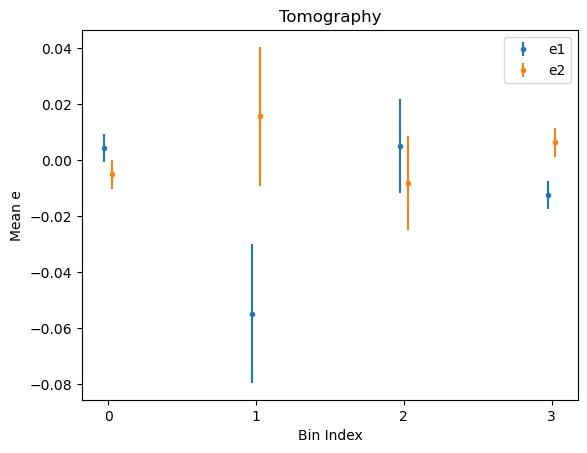

In [33]:
x = np.arange(g["mean_e1"].size)
e1 = g["mean_e1"][:]
e2 = g["mean_e2"][:]

N_eff = g["N_eff"][:]
sigma_e = g["sigma_e"][:]
error_on_mean = sigma_e / np.sqrt(N_eff)


plt.title("Tomography")
plt.ylabel("Mean e")
plt.xlabel("Bin Index")
plt.xticks([0, 1, 2, 3])
dx = 0.025
plt.errorbar(x-dx, e1, error_on_mean, fmt='.', label='e1')
plt.errorbar(x+dx, e2, error_on_mean, fmt='.', label='e2')
plt.legend()

---

# Redshift PDFs: lens p(z)  <a class="anchor" id="photoz-pdfs"></a>

For every lens (foreground) galaxy there is a probability distribution function (PDF) of the galaxy redshift[<sup>1</sup>](#fn1). 


The PDFs are stored in a [QP](https://github.com/LSSTDESC/qp) file. It stores the redshift sample points as an array `xvals`, and the PDF values in one called `yvals`. The ordering of this array matches the one in the input catalog.  In this sample there are 82200 galaxies with 301 p(z) sample values for each. 


Summary statistics like the mean and modal z are also stored (`zmean` and `zmode`)


<span id="fn1">[1] This particular pipeline does not compute PDFs of individual source galaxies.</span>

In [10]:
lens_pdfs = h5py.File("./data/example/outputs_metadetect/lens_photoz_pdfs.hdf5")
print("Root:", lens_pdfs.keys()) 

group = lens_pdfs['data']
print("Group:", group.keys())

z = lens_pdfs["meta/xvals"][:]
pdfs = lens_pdfs["data/yvals"][:]

print("z shape:", z.shape)
print("pdfs shape:", pdfs.shape)

# z is currently stored as a 1 x n array, so we should cut it down.
z = z[0]

zmean = lens_pdfs["ancil/zmean"][:]
zmode = lens_pdfs["ancil/zmode"][:]


Root: <KeysViewHDF5 ['ancil', 'data', 'meta']>
Group: <KeysViewHDF5 ['yvals']>
z shape: (1, 301)
pdfs shape: (82200, 301)


In [11]:
zmode.shape

(82200,)

First let's look at a histogram of the mean and mode redshifts:

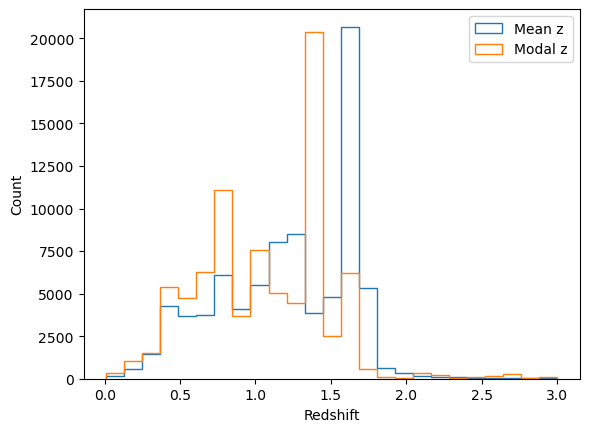

In [12]:
plt.hist(zmean, histtype='step', bins=25, label='Mean z')
plt.hist(zmode, histtype='step', bins=25, label='Modal z')
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.legend();

We can also plot some randomly chosen galaxy PDFs. Let's pick a few.

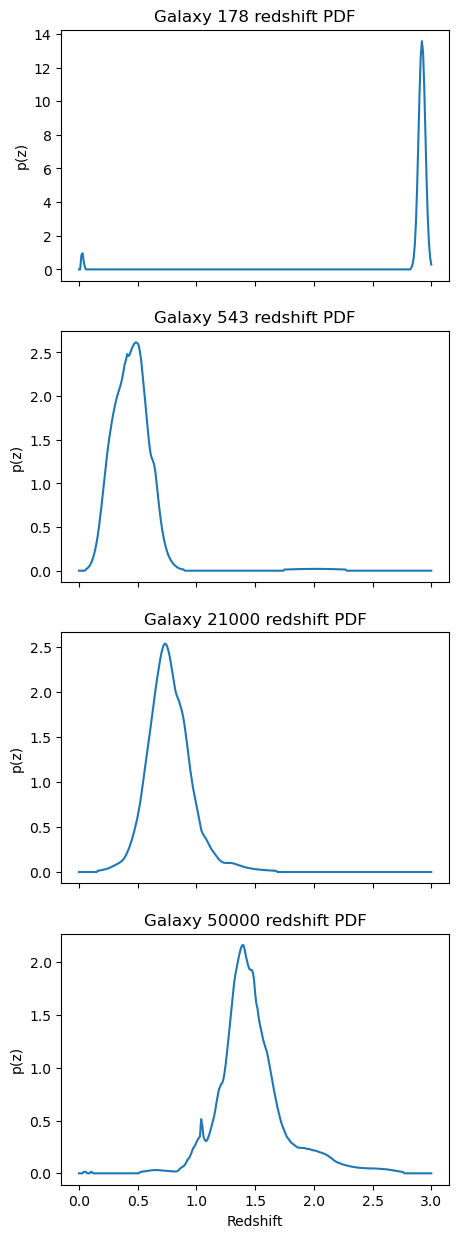

In [13]:

indices = [178, 543, 21000, 50000]
fig, axes = plt.subplots(nrows=len(indices), ncols=1, figsize=(5, 15), sharex=True)
plt.xlabel('Redshift')
for j,i in enumerate(indices):
    axes[j].plot(z, pdfs[i])
    axes[j].set_title(f'Galaxy {i} redshift PDF')
    axes[j].set_ylabel('p(z)')


Let's overlay PDFs for a large set of galaxies. 

Text(0.5, 1.0, 'Probability Density Funcation vs Redshift')

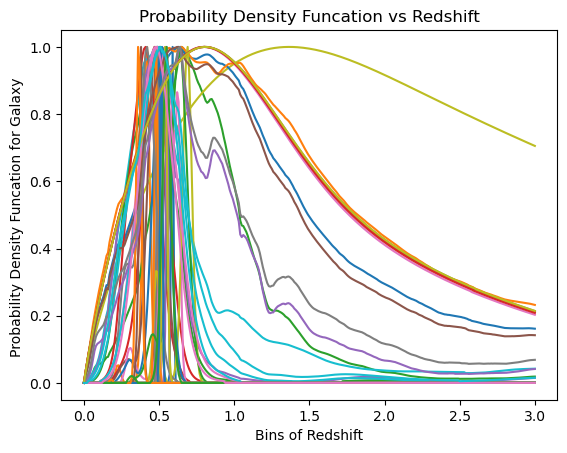

In [14]:
for i in range(10000,12000,50):
    # Normalize to peak 1 to avoid very spiky PDFs dominating
    plt.plot(z, pdfs[i] / pdfs[i].max())
plt.xlabel('Bins of Redshift')
plt.ylabel('Probability Density Funcation for Galaxy ')
plt.title('Probability Density Funcation vs Redshift')

---

# Redshift distributions: source n(z)  <a class="anchor" id="photoz-bins"></a>

Now if we want to look at the values of the tomographic bin galaxy redshift distribution we can find these in `shear_photoz_stack.hdf5`. This is another QP file, so you can read it with either the qp library, directly as an HDF5 file, or via the TXPipe interface:

In [15]:
stack = txpipe.data_types.QPNOfZFile("./data/example/outputs_metadetect/shear_photoz_stack.hdf5", "r")

Number of bins =  4


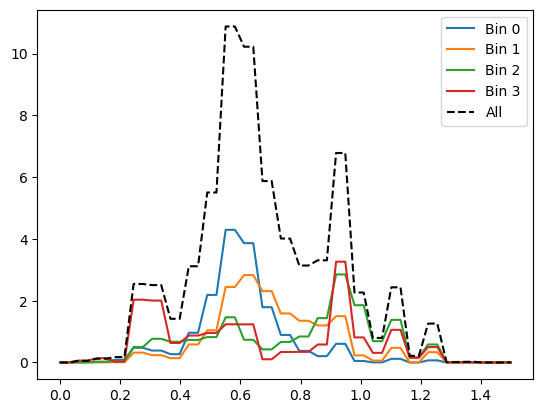

In [16]:
nbin = stack.get_nbin()
print("Number of bins = ", nbin)
for i in range(nbin):
    z, nz = stack.get_bin_n_of_z(i, zmax=1.5, nz=50)
    plt.plot(z, nz, label=f'Bin {i}')
z, nz = stack.get_2d_n_of_z(zmax=1.5, nz=50)
plt.plot(z, nz*nbin, 'k--', label='All')
plt.legend()

You can also access the QP "ensemble" object directly:

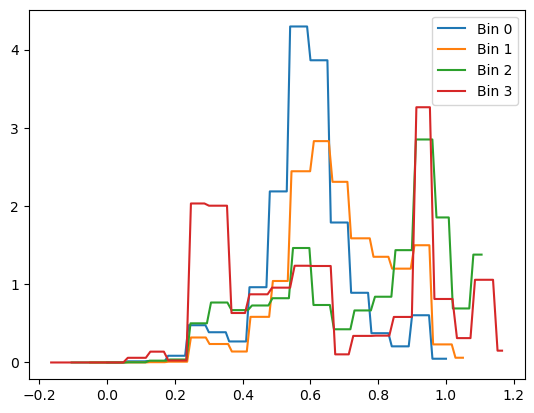

In [17]:
with txpipe.data_types.QPNOfZFile("./data/example/outputs_metadetect/shear_photoz_stack.hdf5", "r") as stack:
    ensemble = stack.read_ensemble()
    

nbin = ensemble.npdf - 1 # This -1 is because the combined n(z) is also stored, at the end.
fig, axes = plt.subplots()
for i in range(nbin):
    ensemble.plot(i, axes=axes, label=f'Bin {i}')
plt.legend()

---

# Null test plots & data: the brighter-fatter effect <a class="anchor" id="brighter-fatter"></a>

One stage makes plots to check for the impact of the [brighter-fatter effect](https://arxiv.org/abs/1402.0725).

It makes a plot, but also saves the data points that go into that plot separately.

In [18]:
bf = h5py.File("./data/example/outputs_metadetect/brighter_fatter_data.hdf5")

print("Root:", bf.keys())
print("Group:", bf["brighter_fatter"].keys())
print("Sub-group:", bf["brighter_fatter/PSF-used"].keys())


Root: <KeysViewHDF5 ['brighter_fatter', 'provenance']>
Group: <KeysViewHDF5 ['PSF-reserved', 'PSF-used']>
Sub-group: <KeysViewHDF5 ['delta_T', 'delta_T_error', 'delta_e1', 'delta_e1_error', 'delta_e2', 'delta_e2_error', 'mag']>


TXPipe output files also contain provenance metadata that describe how they were made.

This includes the stage that made it, the configuration options, and the versions of all the python modules it loaded.

The data is stored in an HDF5 "Attributes" section, which we can convert to a dictionary and explore.


In [19]:
prov = dict(bf["provenance"].attrs)

# Just print the first 20 items as there are lots of them
for (k, v) in list(prov.items())[:20]:
    print(k, v)

config/band r
config/brighter_fatter_data data/example/outputs_metadetect/brighter_fatter_data.hdf5
config/brighter_fatter_plot data/example/outputs_metadetect/brighter_fatter_plot.png
config/chunk_rows 100000
config/config examples/metadetect/config.yml
config/cprofile 
config/memmon 0
config/mmax 23.5
config/mmin 18.5
config/name TXBrighterFatterPlot
config/nbin 20
config/nside 64
config/pdb False
config/pixelization healpix
config/sparse True
config/stage_name TXBrighterFatterPlot
config/star_catalog data/example/inputs/star_catalog.hdf5
config/trace False
creation 2025-09-18T15:03:24.030145
domain 1.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.ip6.arpa


This stage also makes a plot as a PNG file:

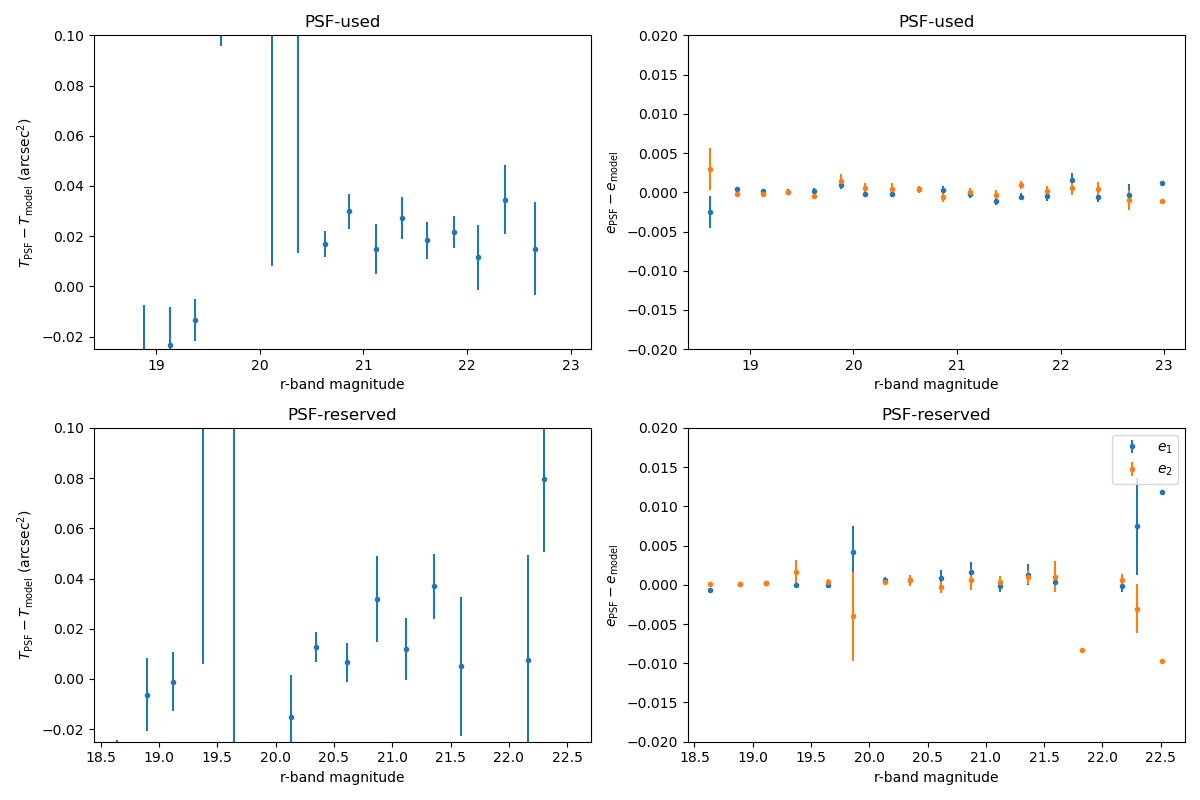

In [20]:
Image(filename='data/example/outputs_metadetect/brighter_fatter_plot.png') 

----


# Maps: source catalog maps <a class="anchor" id="source-maps"></a>

TXPipe Generaetes a set of maps, in [healpix](https://healpy.readthedocs.io/en/latest/tutorial.html) format by default.

TXPipe map files use the class `txpipe.data_types.MapsFile`. This can read, write, and plot maps in either the default Heapix or alternative planar form.

First, let's use this class to look at a map. Because our maps are made at low resolution for this fast example the maps are not very interesting!

count_0, count_1, count_2, count_2D, count_3, g1_0, g1_1, g1_2, g1_2D, g1_3, g2_0, g2_1, g2_2, g2_2D, g2_3, lensing_weight_0, lensing_weight_1, lensing_weight_2, lensing_weight_2D, lensing_weight_3, var_e_0, var_e_1, var_e_2, var_e_2D, var_e_3, var_g1_0, var_g1_1, var_g1_2, var_g1_2D, var_g1_3, var_g2_0, var_g2_1, var_g2_2, var_g2_2D, var_g2_3


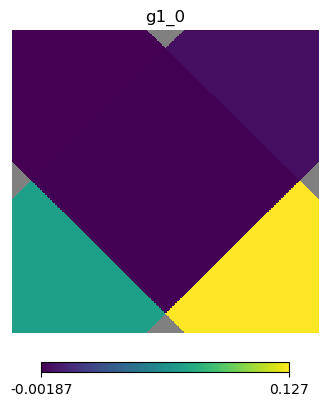

In [21]:
f = txpipe.data_types.MapsFile("./data/example/outputs_metadetect/source_maps.hdf5", "r")

# This method lists all the maps stored in the file.
map_names = f.list_maps()
print(", ".join(map_names))

# This plots one healpix map
f.plot_healpix("g1_0")

You can also get basic map resolution information directly without loading the map:

In [22]:
f.read_map_info("g1_1")

{'chunk_rows': np.int64(100000),
 'dec_cent': np.float64(nan),
 'nbin': np.int64(4),
 'nbin_source': np.int64(4),
 'nest': np.False_,
 'npix': np.int64(49152),
 'npix_x': np.int64(-1),
 'npix_y': np.int64(-1),
 'nside': np.int64(64),
 'pixel_size': np.float64(nan),
 'pixelization': 'healpix',
 'ra_cent': np.float64(nan),
 'sparse': np.True_}

You don't have to use the class to explore the data - you can also dig in directly if you really prefer. The underlying file object is exposed as `f.file`.

Maps are stored as two arrays, a pixel index and value. Unobserved values are not stored. We can look at the first 10 values, for example.

In [23]:
print("Root keys", f.file.keys())

group = f.file["maps/g1_0"]
print("Map keys:", group.keys())
print(f.file["maps/g1_0/pixel"][:10])
print(f.file["maps/g1_0/value"][:10])


Root keys <KeysViewHDF5 ['maps', 'provenance']>
Map keys: <KeysViewHDF5 ['pixel', 'value']>
[36778 36779 37035 37290 37291]
[ 0.00297968 -0.00187146 -0.00130367  0.12708714  0.07085132]


We can also plot maps manually using `healpy`.

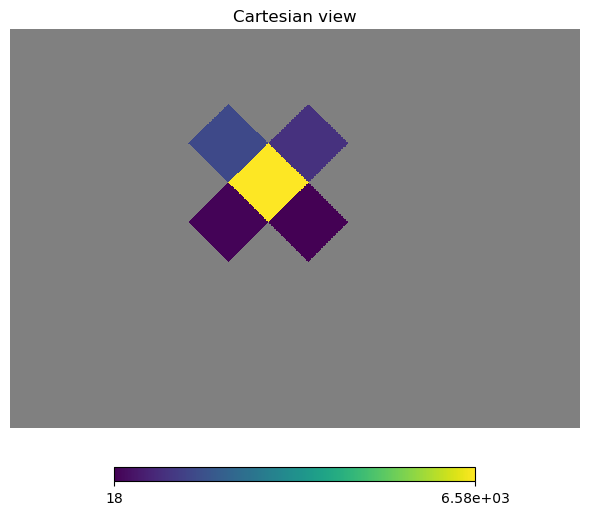

In [24]:
m = f.read_map("lensing_weight_2D")
healpy.cartview(m, lonra=[55,65], latra=[-35, -28])

## Available maps in `source_maps`


- `g1_X` and `g2_X` maps are the two components of the reduced shear for the tomographic bin X. If X == `2D` then this means  the combined non-tomographically-split sample.
- `lensing_weight_X` maps are the total weight of all sources in that pixel in bin X.
- `var_e_X` maps are the two-component ellipticity variance per pixel.
- `var_g1_X` maps the shear variance per pixel


---

# Measurements in SACC files

Cosmology measurements from TXPipe are stored in SACC files, which document them very specifically and include the metadata you need to perform parameter inference.

You should always explore and use SACC files using the official SACC library instead of trying to manually read them.

In [25]:
s = sacc.Sacc.load_fits("./data/example/outputs_metadetect/twopoint_data_fourier.sacc")

Data points in sacc files each have a data type which indicates what they contain. We can list all the types in the file like this:

In [26]:
s.get_data_types()

['galaxy_density_cl',
 'galaxy_shearDensity_cl_b',
 'galaxy_shearDensity_cl_e',
 'galaxy_shear_cl_bb',
 'galaxy_shear_cl_be',
 'galaxy_shear_cl_eb',
 'galaxy_shear_cl_ee']

SACC data points are described by one more *tracers*, which in this case correspond to tomographic bin pairs (in other file they might correspond to other identifiers like cluster sample subsets).

We can get all the tracer combinations in the file, or for a specific data type by specifying it as the first argument:

In [27]:
s.get_tracer_combinations("galaxy_density_cl")

[(np.str_('lens_0'), np.str_('lens_0')),
 (np.str_('lens_1'), np.str_('lens_0')),
 (np.str_('lens_1'), np.str_('lens_1'))]

Our 1 square degree sample is small enough to be almost pure noise, but we can extract and plot the data in it nonetheless.

Let's pull out the data for type `galaxy_density_cl` (the clustering measurement) and the auto-correlation for the first lens bin.

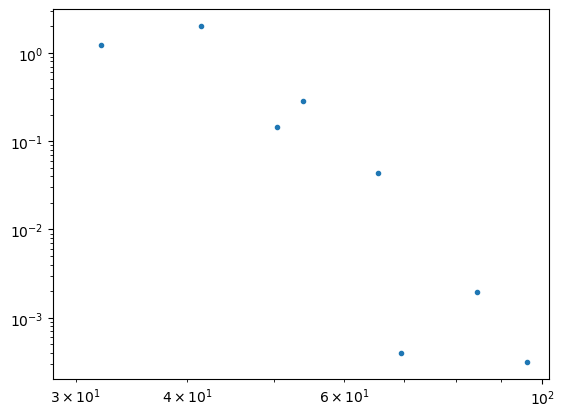

In [28]:
ell = s.get_tag("ell", "galaxy_density_cl", ('lens_0', 'lens_0'))
C_ell = s.get_mean("galaxy_density_cl", ('lens_0', 'lens_0'))
plt.loglog(ell, C_ell, '.')

The SACC files made in this pipeline have no covariance or error bars,
because the covariance stages are slightly too long to run for this example.  You can add a covariance and make some relevant plots by uncommenting the cells below. It will take about 5 minutes.


In [29]:
config2 = ceci.Pipeline.build_config(config_filename)
config2['stages'].append({"name": "TXFourierTJPCovariance"})
pipeline2 = ceci.Pipeline.create(config2)
pipeline2.run()

Skipping stage FlowCreator because its outputs exist already
Skipping stage TXStarCatalogSplitter because its outputs exist already
Skipping stage TXAuxiliaryLensMaps because its outputs exist already
Skipping stage TXPSFDiagnostics because its outputs exist already
Skipping stage TXBrighterFatterPlot because its outputs exist already
Skipping stage GridSelection because its outputs exist already
Skipping stage TXSimpleMaskFrac because its outputs exist already
Skipping stage TXParqetToHDF because its outputs exist already
Skipping stage PZPrepareEstimatorLens because its outputs exist already
Skipping stage NZDirInformerLens because its outputs exist already
Skipping stage TXSourceSelectorMetadetect because its outputs exist already
Skipping stage NZDirInformerSource because its outputs exist already
Skipping stage PZEstimatorLens because its outputs exist already
Skipping stage TXShearCalibration because its outputs exist already
Skipping stage TXSourceNoiseMaps because its outputs e


*************************************************
Error running pipeline stage TXFourierTJPCovariance.
Failed after 2.0 seconds.

Standard output and error streams in data/example/logs_metadetect/TXFourierTJPCovariance.out
*************************************************


1

In [30]:
s2 = sacc.Sacc.load_fits("./data/example/outputs_metadetect/summary_statistics_fourier.sacc")
s2.remove_selection('galaxy_shearDensity_cl_b')
s2.remove_selection('galaxy_shear_cl_bb')
s2.remove_selection('galaxy_shear_cl_be')
s2.remove_selection('galaxy_shear_cl_eb')

FileNotFoundError: [Errno 2] No such file or directory: './data/example/outputs_metadetect/summary_statistics_fourier.sacc'

In [ ]:
# ell2, cl2, cov2 = s2.get_ell_cl("galaxy_shear_cl_ee", 'source_0', 'source_0', return_cov=True)
# sigma = abs(cov2.diagonal()) ** 0.5
# plt.errorbar(ell2, cl2, sigma, fmt='.')


In [ ]:
# plt.imshow(np.log10(np.abs(s2.covariance.dense)))
# plt.colorbar()